In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import gensim.downloader
from gensim.models import Word2Vec, KeyedVectors
from natasha import Doc, Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger

import mlxtend
from mlxtend.evaluate import paired_ttest_kfold_cv

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

import matplotlib.pyplot as plt

from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\svden\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
RND_STATE = 73

# Предобработка текста
Чтобы получить более точное и компактное представление текстов, обычно делают нормализацию текста, которая включает в себя следующие этапы:
- lowering
- tokenize
- lemmatize
- remove symbols
- remove stop-words

Для нас совершенно не важен регистр текста, его род и падеж, а также различные символы, которые и вовсе текстом не являются.

Таким образом, мы ожидаем, что после предобработки текста качество модели должно возрасти.

Существуют разные библиотеки для обработки текста, мы будем использовать Наташу, потому что она включяет в себя все необходимые нам элементы предобработки (токенизация и лемматизация), а также демонстрирует сравнительно хорошее качество при работе с русским языком.

In [3]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_target = NewsMorphTagger(emb)

Напишем функцию, которая будет осуществлять всю указанную выше предобработку текста.

In [4]:
def text_prep(text) -> str:
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_target)
    
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
        
    lemmas = [_.lemma for _ in doc.tokens]
    words = [lemma for lemma in lemmas if lemma.isalpha() and len(lemma) > 2]
    filtered_words = [word for word in words if word not in stop_words]
    
    return " ".join(filtered_words)

In [5]:
stop_words = stopwords.words('russian')
stop_words.extend(['что', 'это', 'так',
                    'вот', 'быть', 'как',
                    'в', '—', 'к', 'за', 'из', 'из-за',
                    'на', 'ок', 'кстати',
                    'который', 'мочь', 'весь',
                    'еще', 'также', 'свой',
                    'ещё', 'самый', 'ул', 'комментарий',
                    'английский', 'язык', 'заявил', 'заявили'])

Обработаем доступные нам текстовые поля.

In [6]:
df = pd.read_csv('data_for_nlp_clear.csv')

%time df['title_clean'] = df.title.apply(text_prep)
%time df['subtitle_clean'] = df.subtitle.apply(text_prep)
%time df['content_clean'] = df.text.apply(text_prep)

CPU times: total: 28.2 s
Wall time: 44.1 s
CPU times: total: 25.1 s
Wall time: 50.2 s
CPU times: total: 6min 39s
Wall time: 11min 56s


Сделаем бэкап данных

In [7]:
df.to_csv('second_part_beckap.csv')

Посмотрим, насколько разумно работает наша предобработка, оценив качество преобразования текстовых данных.

In [8]:
# Заголовок
df.sample(1)[['title', 'title_clean']].values

array([['Белоруссия решила отозвать посла в Великобритании  ',
        'белоруссия решить отозвать посол великобритания']], dtype=object)

In [9]:
# Подзаголовок
df.sample(1)[['subtitle', 'subtitle_clean']].values

array([['Врио главы Херсонской области Сальдо опроверг слухи о подготовке наступления ВСУ',
        'врио глава херсонский область сальдо опровергнуть слух подготовка наступление всу']],
      dtype=object)

In [10]:
# Содержание
df.sample(1)[['text', 'content_clean']].values

array([['МОСКВА, 20 авг — РИА Новости. При атаке украинского беспилотника получили повреждения крыша, фасад и платформа железнодорожного вокзала Курска. Об этом губернатор Роман Старовойт сообщил в Telegram-канале.«"Пострадали крыша, фасад, первая платформа. Также в результате взрывной волны есть повреждения в зале ожидания и пешеходном тоннеле", — написал он.По словам губернатора, в ближайшее время специалисты начнут ремонтные работы. Посадка на поезда сейчас осуществляется через северную и южную стороны без входа в вокзал.Старовойт рассказал также, что в момент взрыва в здании находилось 50 пассажиров. Их оперативно эвакуировали. Минувшей ночью украинский беспилотник атаковал здание железнодорожного вокзала в Курске. Там начался пожар, но его вскоре потушили. Пять человек получили легкие ранения. По информации губернатора, двое из них отказались от врачебной помощи, троих отправили в областную больницу, но после осмотра отпустили домой.Курская область постоянно подвергается обстрелам

# Word2Vec

Давайте теперь применим альтернативный подход к представлению слов - Word2Vec. Этот метод основывается на семантической близости слов (по центральному слову предсказывает контекст или же по контексту предсказывает центральное слово). Построим модель на нашей выборке новостей.

In [11]:
model = Word2Vec(sentences=df.title_clean.str.split(),
                 vector_size=200,
                 min_count=10,
                 window=2,
                 seed=RND_STATE)

In [12]:
model.wv.most_similar(positive=['владимир'])

[('лес', 0.9978578090667725),
 ('отец', 0.9976714849472046),
 ('выбросить', 0.997373640537262),
 ('труба', 0.9973010420799255),
 ('кемерово', 0.9972942471504211),
 ('авария', 0.9972772598266602),
 ('красноярск', 0.9970983862876892),
 ('мигрант', 0.9970702528953552),
 ('алкоголь', 0.9970579147338867),
 ('ипотека', 0.9970191717147827)]

Видим, что все выглядит очень логично и даже увлекательно :)

Чтобы построить модель, нам нужно получить вектора для предложения. Это можно сделать двумя способами:
- Усреднить вектора слов, входящих в предложение
- Взвесить вектора слов, входящих в предложение на основании их tf-idf весов

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df.content_clean.str.split(),
                                                    df.topic.values,
                                                    random_state=RND_STATE)

model = Word2Vec(sentences=X_train,
                 vector_size=200,
                 min_count=10,
                 window=2,
                 seed=RND_STATE)

Для того, чтобы по-прежнему использовать `Pipeline`, оформим описанные выше подходы в классы.

In [14]:
class MeanEmbeddingVectorizer(object):
    """
    Get mean of vectors
    
    """
    
    def __init__(self, model):
        self.word2vec = model.wv
        self.dim = model.vector_size
        
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec.get_vector(w)
                for w in words if w in self.word2vec] or
                [np.zeros(self.dim)], axis=0)
            for words in X])
        

In [21]:
pipe = Pipeline([('w2v', MeanEmbeddingVectorizer(model)),
                 ('clf', LogisticRegression(random_state=RND_STATE,
                                            max_iter=1000))])

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

                precision    recall  f1-score   support

defense_safety       0.84      0.82      0.83      1590
       economy       0.88      0.91      0.90      1633
     incidents       0.89      0.92      0.91      1518
      politics       0.80      0.78      0.79      1543
       society       0.81      0.81      0.81      1274
         world       0.85      0.81      0.83      1506

      accuracy                           0.85      9064
     macro avg       0.84      0.84      0.84      9064
  weighted avg       0.84      0.85      0.84      9064



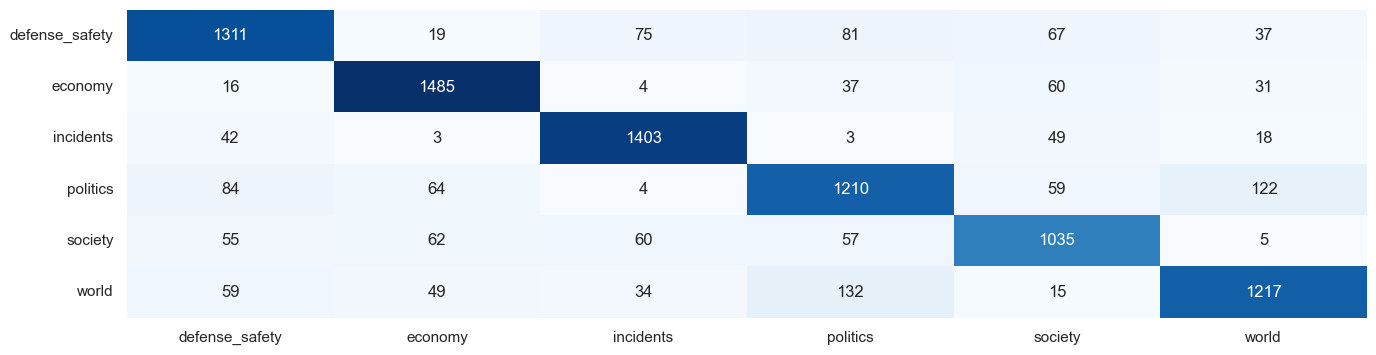

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)

cm_df = pd.DataFrame(data=cm, columns=pipe.classes_, index=pipe.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap='Blues', fmt='d', cbar=False);

Как можно заметить, модель довольно неплохо определяет топик новости. Ошибается модель больше всего в топиках `politics` и `world`, однако, иногда и обычному человеку будет сложно их отделить друг от друга в силу общности топика `world`.

Лучше модель справляется с топиками `economy` и `incidents`